In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
import seaborn as sns
from IPython.display import Image

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [2]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

## Greenland data

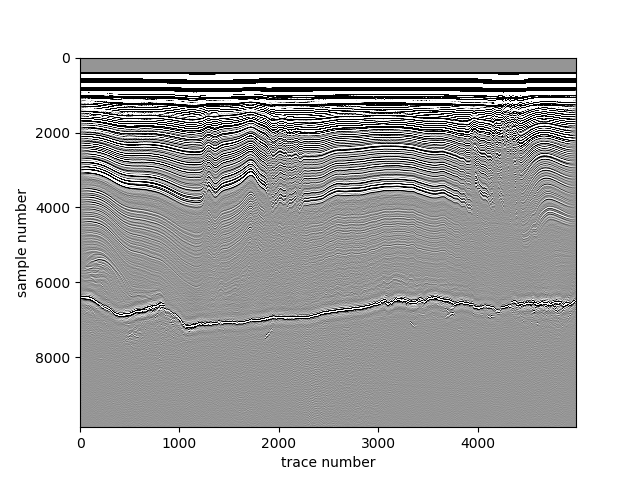

In [3]:
Image(green_image)

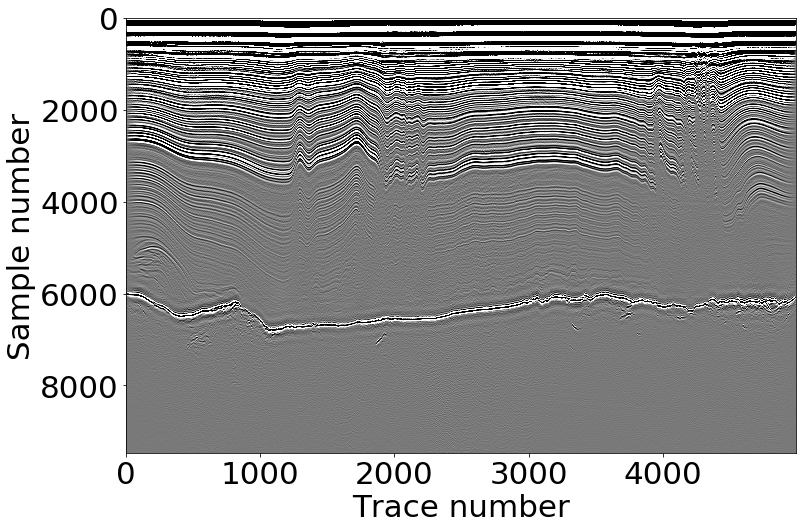

In [4]:
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=31)
plt.ylabel('Sample number', fontsize=31)

ax.tick_params(axis='x', labelsize=31)
ax.tick_params(axis='y', labelsize=31)

#plt.savefig('greenland_line.pdf', format='pdf', bbox_inches='tight')

### Try $G(im)^2 / G(im^2)$

We could also look at convolution as smoothing.
https://stackoverflow.com/questions/17595912/gaussian-smoothing-an-image-in-python

https://stackoverflow.com/questions/14765891/image-smoothing-in-python

In [41]:
#https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian
sig = 6
gim2 = gaussian(data, sigma=sig)**2
im2g = gaussian(data**2, sigma=sig)
cohere = np.divide(gim2, im2g)

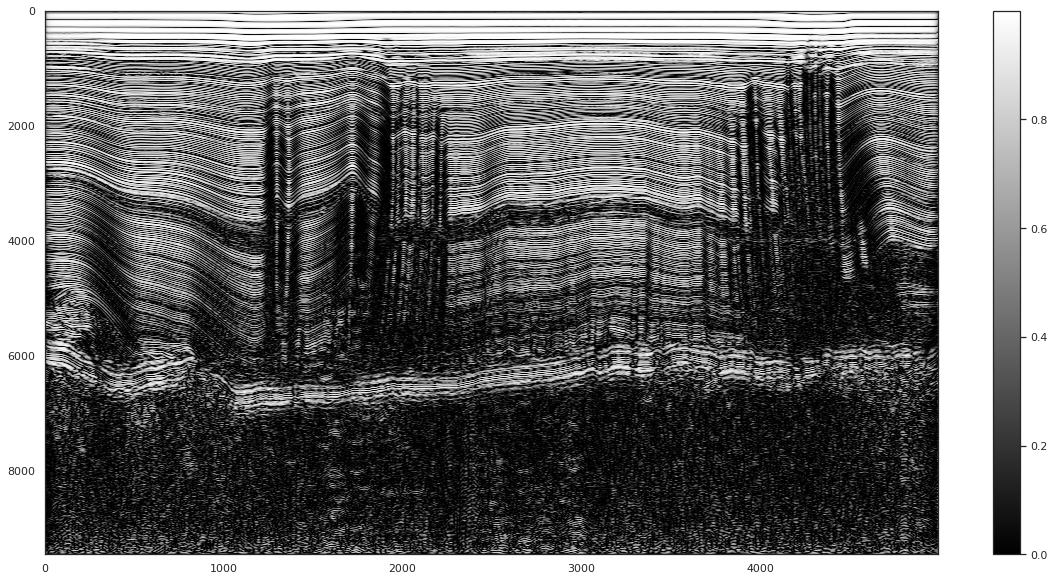

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))
p = ax.imshow(cohere, cmap='gray', aspect='auto')

#plt.xlabel('Trace number', fontsize=31)
#plt.ylabel('Sample number', fontsize=31)

#ax.tick_params(axis='x', labelsize=31)
#ax.tick_params(axis='y', labelsize=31)

fig.colorbar(p)
#ax.set_title('Coherence Map', fontsize=31)

plt.show()

In [14]:
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

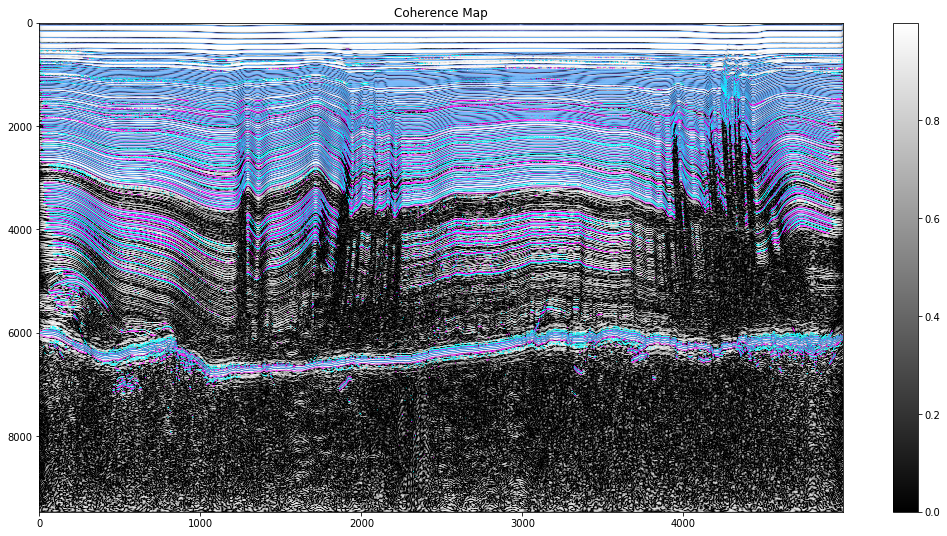

In [15]:
fig, ax = plt.subplots(figsize=(18, 9))
p = ax.imshow(cohere, cmap='gray', aspect='auto')

fig.colorbar(p)
ax.set_title('Coherence Map')

for contour in pos:
    ax.plot(contour[:, 1], contour[:, 0], color='magenta', linewidth=0.5)
    
for contour in neg:
    ax.plot(contour[:, 1], contour[:, 0], color='cyan', linewidth=0.5)
    
plt.show()

In [16]:
print(cohere.ravel().shape)

(47254788,)


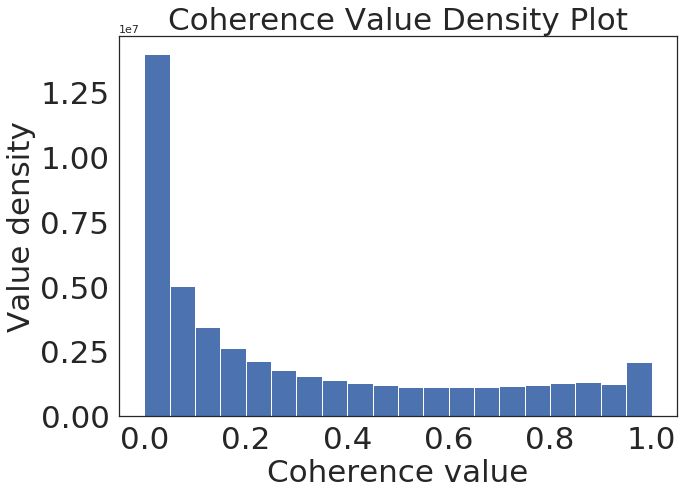

In [43]:
sns.set(style='white')

fig, ax = plt.subplots(figsize=(10, 7))

ax.hist(cohere.ravel(), density=False, bins=20)

plt.xlabel('Coherence value', fontsize=31)
plt.ylabel('Value density', fontsize=31)

ax.tick_params(axis='x', labelsize=31)
ax.tick_params(axis='y', labelsize=31)

ax.set_title('Coherence Value Density Plot', fontsize=31)

plt.show()

In [48]:
#make a mask here and then set everything below some threshold to 0
#or we could use a MaskedArray in numpy so that we could use something like the example below
#https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
mask = copy.deepcopy(cohere)

mask[mask<0.5] = 0

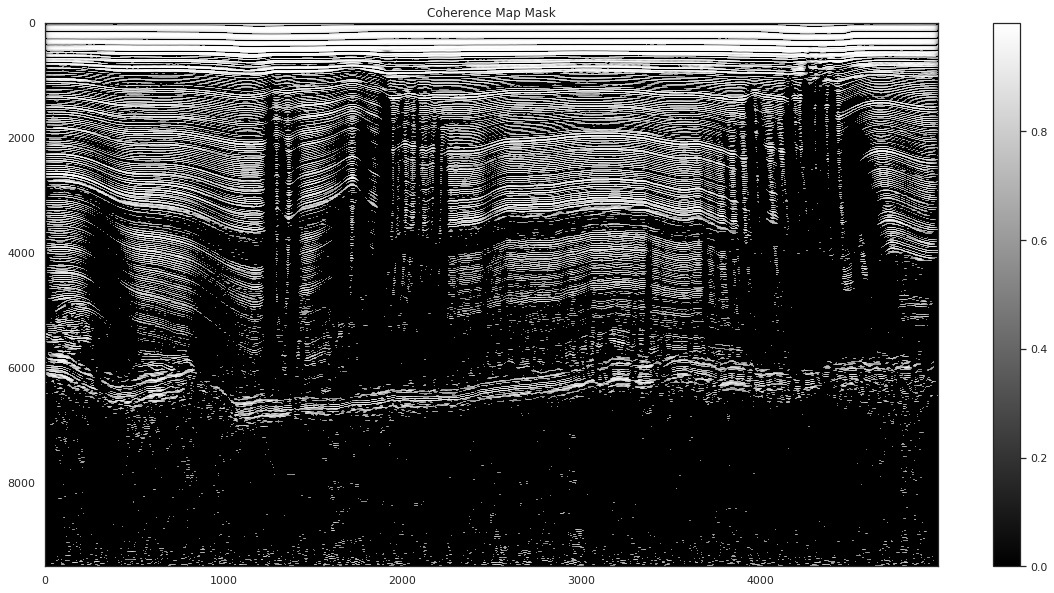

In [76]:
fig, ax = plt.subplots(figsize=(20, 10))
p = ax.imshow(mask, cmap='gray', aspect='auto')

fig.colorbar(p)
ax.set_title('Coherence Map Mask')
    
plt.show()

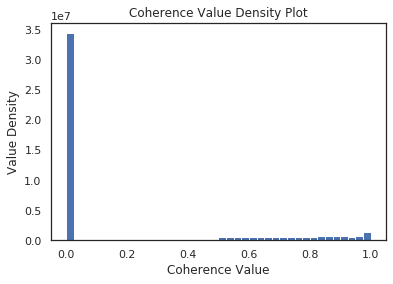

In [50]:
plt.hist(mask.ravel(), density=False, bins=40)
plt.xlabel('Coherence Value')
plt.ylabel('Value Density')
plt.title('Coherence Value Density Plot')

plt.show()

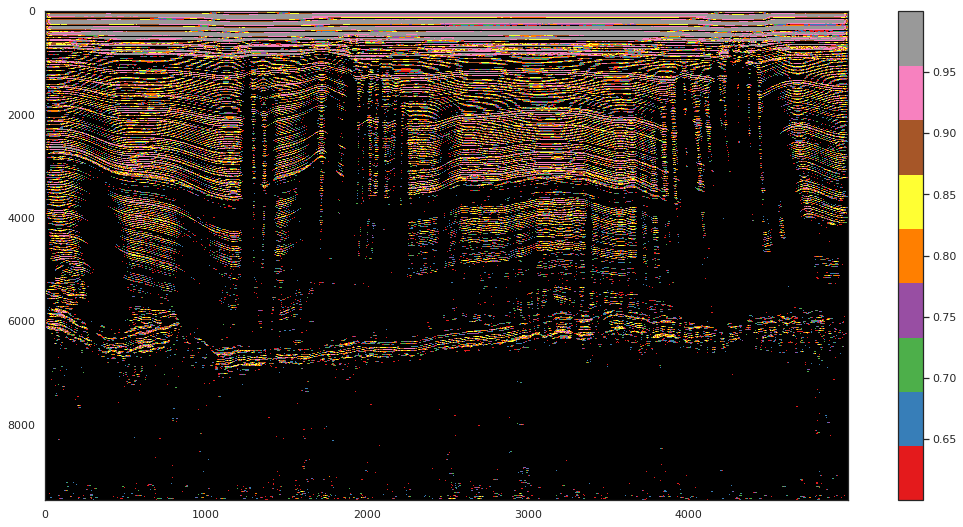

In [52]:
#https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
mask2 = copy.deepcopy(cohere)
value = 0.6
masked_array = np.ma.masked_where(mask2 < value, mask2)

cmap = matplotlib.cm.Set1
cmap.set_bad(color='black')

fig, ax = plt.subplots(figsize=(18, 9))
p = ax.imshow(masked_array, cmap=cmap, aspect='auto')
fig.colorbar(p)

plt.show()

### Can we extract values from the colormap?

We need to be able to process different contours at a time, maybe filter contours as well.

For instance:

```python
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.imshow(data, cmap='gray', aspect='auto')

for i, contour in enumerate(contours):
    c = cm.RdYlBu_r(i/len(contours))
    plt.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=c)
    
for i, contour in enumerate(minus):
    c = cm.RdYlBu_r(i/len(minus))
    plt.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=c)
```
    
Something like this could work! We are already aligning contours by color.

In [87]:
where_high_cohere = mask > 0

In [89]:
print(where_high_cohere.shape)

(9468, 4991)


In [90]:
print(where_high_cohere)

[[False  True  True ...  True False False]
 [False  True  True ...  True False False]
 [False  True  True ...  True False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


**From Ben:**

"I am just going back and looking over what her caption said. If you read the sentence for (D), I think this might be a good approach."

**From Ginevra:**

<img src="horizonpicking.jpg">

"The methodology for automatically identifying coherent reflectors, or geologic contacts, in seismic reflection imagery are shown. The same two axes are included for each panel, one indicating the offset-TWTT (two way travel time) space, and one indicating the sample number along each respective axis. In the 1:1 sample number space, seismic reflection data can be interpreted as a pixelated image. (A)  A seismic reflection image is shown, with red indicating positive pixel values and blue indicating negative pixel values. Black lines indicate the direction perpendicular to the steepest image gradient for a subset of pixels in the image. Longer lines indicate more linear continuity (referred to here as coherence) in that direction. Coherence values are queried from the grid shown in B. (B) A measure of coherence is shown, with darker values indicating higher coherence. Coherence is defined as the amount of similarity between an original pixel and a pixel that has been smoothed in the direction indicated by the vector. Directional coherence lines shown in A are shown again here in red. Note that longer lines correspond to higher coherence values. (C) The zero contour of the image shown in A is indicated in black. The transition from positive to negative pixel values can either be interpreted as a geologic contact or some form of noise. (D) The contours from C are filtered by coherence value shown in B, removing boundaries that would be interpreted as noise. This returns reflectors that would be manually interpreted as geologic contacts. The filtered contours are shown in black."